# Exercise 6) Estuarine Hydrodynamics

## 6.1) Stratified or mixed?

We consider an estuary with a constant width and depth, which is fed by fresh water from a river at the landward side and forced by a tidal signal with a distinct spring neap cycle on the seaward side. 
The numbers are:

- Width $W$ = 200 m
- Chézy friction value $C$ = 65 m$^{1/2}$/s
- Depth at mouth $h_{mouth}$ = 10 m
- Fresh water discharge $Q_f$ = 200 m$^3$/s
- Tidal component $M2$ = 0.6 m
- Tidal component $S2$ = 0.3 m

a)	Simulate this situation with the model. Describe the salinity structure.

b)	How far does the salt intrude into the estuary? How does this differ between neap and spring tide?

c)	Investigate the influence of changes in river discharge and tidal amplitude on the stratification. Can you find a condition for which the estuary is well-mixed?

d)	The estuary is expected to experience a significant sea level rise. Go back to the original conditions and simulate sea level rise by increasing the mean water level. What is the effect of sea level rise on the stratification? And how does it influence salt intrusion?

## 6.2) Harbor

For shipping purposes, harbor basins are constructed at the side of the estuary at various locations along the estuary. One basin is at a location that is reached by the salt coming from the sea. Another experiences tidal water level fluctuations, but is beyond the salt intrusion length. The third basin is in the riverine stretch of the estuary.

a)	What happens to the flow and salinity in the first harbor basin at the moment the tip of the salt wedge passes the entrance of the basin? To discuss this, draw a cross section over the width of the river plus the length of the harbor basin at the location of the harbor basin, and sketch the salinity contours.

## 6.3) Classification

Estuaries can be classified for their vertical salinity structure. This can be done in various ways. In essence, most methods make use of a ratio between buoyancy and mixing. Buoyancy is the result of freshwater inflow from the river side. Mixing is attributed to the tidal energy. 

A quite straightforward way to classify an estuary, is by making use of the Estuarine Richardson number $Ri_E$, with:

\begin{equation}
    Ri_E = \frac{\Delta \rho_0 g h }{\rho} \frac{Q_f}{A_0} \frac{1}{u^3_t}
\end{equation}
  
With $Ri_E$ < 0.08 indicating a well-mixed estuary, and $Ri_E$ > 0.8 a salt wedge estuary, and a partially stratified regime in between.

a)	Estimate the Estuarine Richardson number for the conditions you tested in 6.1), using $\Delta \rho$ = 30 psu, $g$ = 9.81 m/s$^2$, $A_0$ is the cross sectional area at the mouth, and $u_t$ the tidal velocity amplitude. Does the prediction of the regime according to the Estuarine Richardson number match your model result?


In [1]:
# Imports
import bmi
import bmi.wrapper
import ipywidgets as widgets
from ipywidgets import HBox, VBox, interactive, Layout, interact
import numpy as np
import time
# Something very fishy happening if I don't define a plot first.
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib notebook
import matplotlib.pyplot as plt
import sys
plt.ioff()
_ = plt.figure()
plt.ion()

# Toggle button for hiding the raw code
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


In [2]:
import os
basepath = (os.path.abspath(os.path.join(os.getcwd(),"..","..")))
engine = basepath+r"\dflowfm_exe\oss_artifacts_x64_65957\x64\share\bin\dflowfm"
mdufile = basepath+r"\6. Estuary\Models\f5s_new.mdu"

In [3]:
data = []
items = []
wrapper = bmi.wrapper.BMIWrapper(engine=engine, configfile=mdufile)
wrapper.initialize();

In [4]:
# for i in range(wrapper.get_var_count()):
#   print(wrapper.get_var_name(i), wrapper.get_var_shape(wrapper.get_var_name(i)))

In [5]:
# print(wrapper.get_var("ndxi"))

In [6]:
SURFACE = []

In [7]:
maxsteps = 10000
parameters = [
#     {
#         "parameter": "s1",
#         "description": "free surface",
#         "default": 4
#     },    
    {
        "parameter": "zbndq",
        "description": "Boundary Discharge Upstream $[m^3/s]$",
        "default": 200
    },    
    
    {
        "parameter": "frcu",
        "description": r"Roughness Chézy $[\sqrt{m}/s]$",
        "default": str(wrapper.get_var("frcu")[0])
    }
]

parameters2 = [
     {
        "parameter": "par_M2",
        "description": r"M2",
        "default": 0.6
    },
    
        {
        "parameter": "par_S2",
        "description": r"S2",
        "default": 0.3
    }
]


In [8]:
# Create widgets
style = {'description_width': 'initial'}

run = widgets.Button(
    description='Run model',
    button_style='',
    icon='play'
)
update = widgets.Button(
    description='Single update',
    button_style='',
    tooltip='Update with 1 timestep',
    icon='step-forward'
)
restart = widgets.Button(
    description='Restart model',
    button_style='',
    tooltip='Restart entire model with initial inputs',
    icon='retweet'
)

settings = widgets.HTML(
    value="Welcome!",
    placeholder='Input settings'
)

play = widgets.Play(
#     interval=10,
    value=0,
    min=0,
    max=int(wrapper.get_end_time()),
    step=1,
    description="Press play",
    disabled=False
)


nsteps = widgets.BoundedIntText(
    description="Number of timesteps",
    value=500,
    min=0,
    max=maxsteps,
    style=style,
    layout=Layout(width='15vw')
)



slider = widgets.IntSlider(  
    min=0,
    max=1,
    value=0
)

sliceslider = widgets.IntSlider(  
    description="Change position of slice",
    min=0,
    max=1,
)

widgets.jslink((play, 'value'), (slider, 'value'))
player = widgets.HBox([play, slider])


items=[]
items2=[]

for p in parameters: 
    items.append(widgets.Text(
        description=p["description"],
        disabled=False,
        value=str(p["default"]),
        placeholder=p["parameter"],
        style=style,
        layout=Layout(width='50vw')
    ))
for p in parameters2: 
    items2.append(widgets.Text(
        description=p["description"],
        disabled=False,
        value=str(p["default"]),
        placeholder=p["parameter"],
        style=style,
        layout=Layout(width='50vw')
    ))

In [9]:
# Model specific function 
xz = wrapper.get_var('xz')[:] 

# print(xz)
yz = wrapper.get_var('yz')[:]
# xu = wrapper.get_var('xu')[:]

indy = np.argsort(yz)[::-1]
newx = xz[indy]
randind = np.random.choice(len(xz), int(len(xz)/5), replace=False)


lX = len(np.unique(xz))
lY = len(np.unique(yz))

time_array = []
surface_array = []

newx = newx.reshape((lY, lX))
indx = np.argsort(newx, axis=1)

Z = int((len(wrapper.get_var('zws')) - lX) / lX)



Xarr = np.tile(xz, (Z, 1))


#     Automate parameter and grid sizes
def update_data():
    ucx = wrapper.get_var('ucx')[lX:].copy()
    ucy = wrapper.get_var('ucy')[lX:].copy()
    
    
    zws = wrapper.get_var('zws')[lX:].copy()
    sal = wrapper.get_var('sa1')[lX::].copy()
    bl = wrapper.get_var('bl')[lX::].copy()
    
    s1 = wrapper.get_var('s1')[:].copy()
#     print(s1.shape)
 


    data.append(dict({
        "time": wrapper.get_current_time(),
        "ucx": ucx.reshape((lX, Z)).transpose(), 
        "ucy": ucy.reshape((lX, Z)).transpose(), 
        "zws": zws.reshape((lX, Z)).transpose(), 
        "temp": sal.reshape((lX, Z)).transpose(),
        "s1": np.array(s1[:])
    }))
    slider.max = len(data)
    settings.value = "Model update, timestep: {}".format(data[-1]["time"])
update_data()


In [10]:
# data[-1]['zws']

In [11]:
sliceslider.max = lX - 1
sliceslider.value = int(lX/6)


In [12]:
#!pip install mako # c-Bjorn: included mako in environment.yml

In [13]:

import pathlib    
import mako.template


wrapper.update()
simulation_dir = pathlib.Path('.') / '..' / 'Estuary_new'
template = simulation_dir / 'sealev.bc.template'
def callback(template, *args, **kwargs):
    kwargs = {
        item.description: float(item.value) 
        for item 
        in items2
    }
    # open old file
    mako_template = mako.template.Template(filename=str(template.absolute()))
    # fill in template
    result = mako_template.render(**kwargs)
    # write to new file 
    path = simulation_dir / 'sealev.bc'
    with path.open('w') as f:
        f.write(result)

change_param2 = lambda x: callback(template=template)



for item in items2:
    item.observe(change_param2, names='value')

# VBox(items2)    

In [14]:
# Standard functions for button widgets
dostop = False
def update_model(b=None):
#     Update the model with t = 1
    wrapper.update(wrapper.get_time_step())
    if(data[-1]["time"] != wrapper.get_current_time()):
        update_data()

def start_loop(n):
#     Start the loop for running the model continuously
#     while run.value == True: 
    for i in range(n):
        update_model()
        if (wrapper.get_current_time() >= wrapper.get_end_time()):
            stop_model()
            break
        if dostop == True: 
            stop_model()
            break
    stop_model()

def run_model(change=None): 
#     When the run/stop model button is pressed either start the model loop or stop it
    run.disabled = True
    update.disabled = True
    restart.disabled = True
    settings.disabled = True
    nsteps.disabled = True
    sliceslider.disabled = True
#     slider.disabled = True
    
    for i in items:
        i.disabled = True
    for i in items2:
        i.disabled = True

    start_loop(int(nsteps.value))


def stop_model(change=None):
    update.disabled = False
    restart.disabled = False
    run.disabled = False
    sliceslider.disabled = False
    nsteps.disabled = False
    for i in items:
        i.disabled = False
    for i in items2:
        i.disabled = False

    dostop = True

def start_model():
#     start model
    wrapper = bmi.wrapper.BMIWrapper(engine=engine, configfile=mdufile)
    wrapper.initialize()
    update_data()
    for i in range(len(items)): 
        items[i].value = str(parameters[i]['default'])
    for i in range(len(items2)): 
        items2[i].value = str(parameters2[i]['default'])

def restart_model2(b=None):
#     stop the model and call function to restart the model
    slider.value = 0
    print('starting model')
    start_model()
    settings.value = "Restarting model"
        
def restart_model(b=None):
#     stop the model and call function to restart the model
    del data[:]
    slider.value = 0
    wrapper.finalize()
    start_model()
    settings.value = "Restarting model"
    
def change_param(v):
    try:
        v = v.owner
        print('v is owned by this')
    except AttributeError: 
        v = v
    if v.value == "":
        return
    try:
        float(v.value)
        old_par = wrapper.get_var(v.placeholder)
        new_par = np.ones_like(old_par) * float(v.value)
        wrapper.set_var(v.placeholder, new_par)
        settings.value = "Value ({}) has been set to: {}".format(v.description, new_par[0])
        
    except ValueError:
        v.value = str(next((x['default'] for x in parameters if x['parameter'] == v.placeholder), None))
        settings.value = "Not a correct input for {}".format(v.description)
        

import pathlib    
import mako.template


wrapper.update()
simulation_dir = pathlib.Path('.') / '..' / 'Models'
template = simulation_dir / 'sealev.bc.template'

def callback(template, *args, **kwargs):
    kwargs = {
        item.description: float(item.value) 
        for item 
        in items2
    }
    # open old file
    mako_template = mako.template.Template(filename=str(template.absolute()))
    # fill in template
    result = mako_template.render(**kwargs)
    # write to new file 
    path = simulation_dir / 'sealev.bc'
    with path.open('w') as f:
        f.write(result)

change_param2 = lambda x: callback(template=template)



for item in items2:
    item.observe(change_param2, names='value')

# VBox(items2)    



<IPython.core.display.Javascript object>


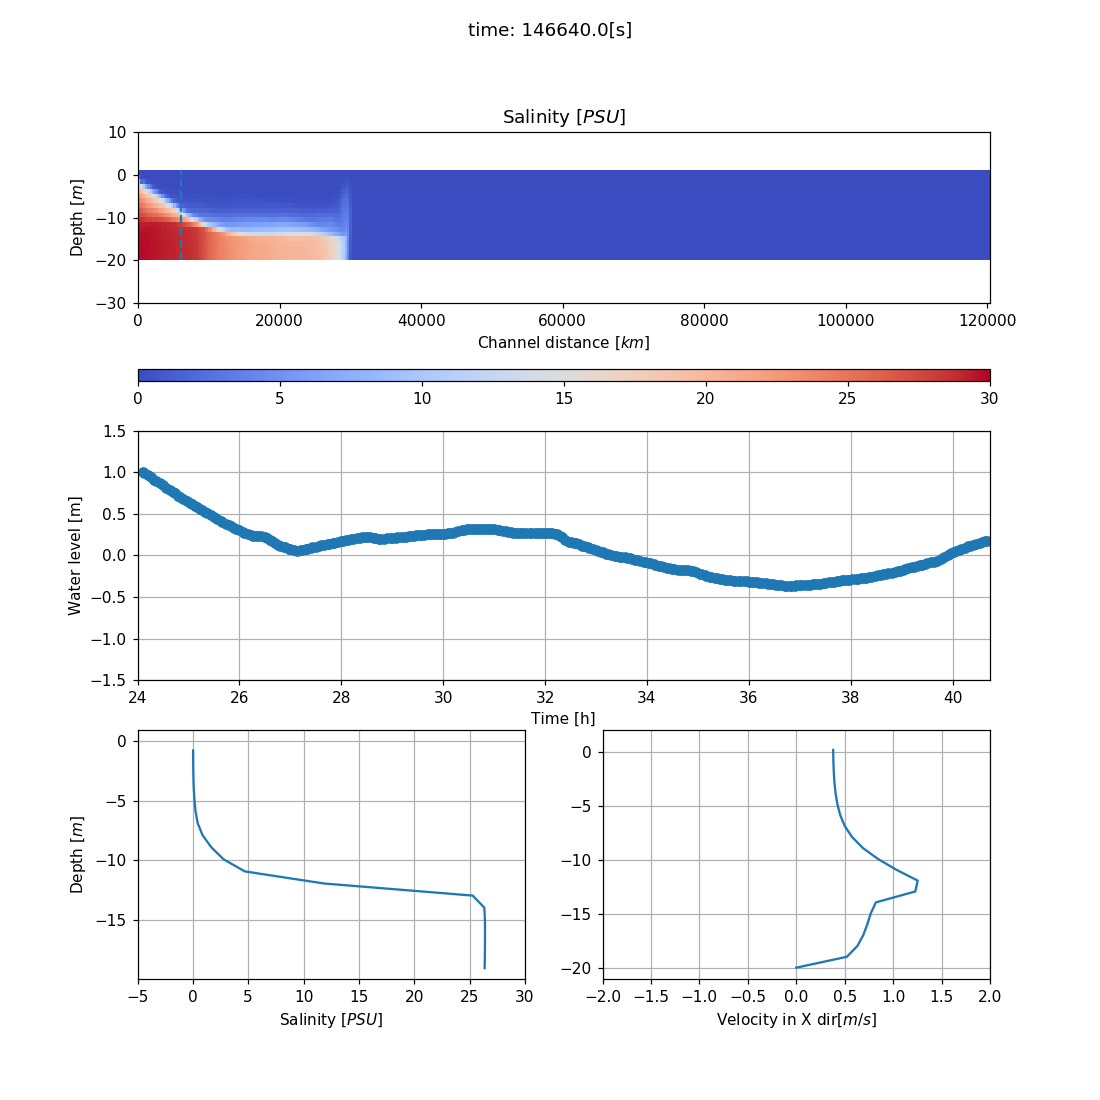

C:\Users\wilms\anaconda3\envs\paotm-2020-b\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Attempting to set identical left == right == 24.0 results in singular transformations; automatically expanding.
C:\Users\wilms\anaconda3\envs\paotm-2020-b\lib\site-packages\numpy\ctypeslib.py:436: RuntimeWarning: Invalid PEP 3118 format string: '<P'
  return array(obj, copy=False)


In [15]:

# set plot size
plt.rcParams["figure.figsize"] = (10, 10) # (w, h)

Xslice = 30
# link functions to widgets
run.on_click(run_model)
update.on_click(update_model)
restart.on_click(restart_model)
timestep = 0

def set_plot(change):
    print(change)
    print('change')
    t = change['new']

    
    ax2.set_xlim([-5,30])
    ax3.set_xlim([-2,2])
    ax0.set_ylim([-30,10])
    settings.value = str(Xslice)
    sal_line.set_data(data[t]['temp'][1:-1, Xslice], data[t]["zws"][1:-1, Xslice])
    vel_line.set_data(data[t]['ucx'][:, Xslice], data[t]["zws"][:, Xslice])


    tt = data[t]['time']/3600.0
    time_array.append(tt)
    ax4.set_ylim(-1.5,1.5)
    ax4.set_xlim(time_array[0],time_array[-1])

    surface_array.append(data[t]['s1'][Xslice])

    surface_plot.set_data(time_array[1:-1], surface_array[1:-1])
    sal.set_data(data[t]["temp"][1:-1,1:-5])

#         vortscat.set_array(data[t]["magR"])
    t1.set_text("time: " + str(data[t]["time"]) + "[s]")
#         quiver.set_UVC(data[t]["ucx"][randind], data[t]["ucy"][randind])
    fig.canvas.draw()
    timestep = t

def set_line(change):
    sliceline.set_data((xz[Xslice], xz[Xslice]), (1, -20))

    ax2.set_xlim([-5,30])
    ax3.set_xlim([-2,2])
    ax4.set_ylim(0.0,2.0)
    ax4.set_xlim(time_array[0],time_array[-1])
    surface_plot.set_data(time_array[timestep], surface_array[timestep])
    sal_line.set_data(data[timestep]['temp'][:, Xslice], data[timestep]["zws"][:, Xslice])
    vel_line.set_data(data[timestep]['ucx'][:,Xslice], data[timestep]["zws"][:, Xslice])
    fig.canvas.draw()
    
    
slider.observe(set_plot, 'value')
sliceslider.observe(set_line, 'value')
              

controls = HBox([run, update, restart])
params = VBox(items+items2)
# params2 = VBox(items2)



for i in items: 
    change_param(i)
    i.observe(change_param, names='value')

for i in items2: 
    change_param2(i)
    i.observe(change_param2, names='value')

display(VBox([settings, HBox([nsteps, controls]), HBox([params]), sliceslider]))
# display(VBox([settings, HBox([nsteps, controls]), HBox([params2]), sliceslider]))
fig = plt.figure()
# ax0 = plt.subplot2grid((2, 3), (0, 0), colspan=3)
# ax2 = plt.subplot2grid((2, 3), (1, 0), rowspan=1)
# ax3 = plt.subplot2grid((2, 3), (1, 1), rowspan=1)
ax0 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 2), (2, 0))
ax3 = plt.subplot2grid((3, 2), (2, 1))
ax4 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
display(player)

t1 = fig.suptitle("time: " + str(data[0]["time"]) + "[s]")
salinity = data[0]["temp"]
tt = data[0]['time']/3600.0
time_array.append(tt)
# time_array.append(data[0]['time']/3600)
surface_array.append(data[0]['s1'][Xslice])
surface_plot, = ax4.plot(time_array,surface_array,'o')
ax4.set_ylim(-1.5,1.5)
ax4.set_xlim(time_array[0],time_array[-1])
# ax0.set_xticklabels(np.arange(xz.min()*100, xz.max()*100, 5000))

sal = ax0.imshow(data[0]["temp"][1:-1,1:-5], cmap="coolwarm", extent=[ xz.min(), xz.max(), 1, -20  ], 
                           vmin=0, vmax=30,interpolation='nearest', aspect='auto')


zws = data[0]['zws']

zz = np.mean(zws, axis=0)
zws_avg = zws
# for i in range(0,zws.shape[0]):
#     zz = zws[i]
# plt.scatter(xz, data[0]['zws'])
ax0.set_xlabel("Channel distance $[km]$")
ax0.set_ylabel("Depth $[m]$")
# quiver = ax0.quiver(Xarr[::5, ::5], data[0]["zws"][::5, ::5], data[0]["ucx"][::5, ::5], data[0]["ucy"][::5, ::5], angles='xy', scale_units='xy', scale=0.0001)
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes('bottom', size='7%', pad=0.6)
cbar = plt.colorbar(sal, orientation='horizontal', cax=cax0);

sliceline, = ax0.plot((xz[Xslice], xz[Xslice]), (zws.min(),zws.max() ), "--")
ax0.set_ylim([10,-30])
ax0.invert_yaxis()


ax0.set_title('Salinity $[PSU]$')


# ax0.set_xticklabels(np.arange(xz.min()*100, xz.max()*100, 5000))
sal_line, = ax2.plot(data[0]['temp'][1:-1,Xslice], data[0]['zws'][1:-1, Xslice])
ax2.set_xlabel('Salinity $[PSU]$')
ax2.set_ylabel('Depth $[m]$')


vel_line, = ax3.plot(data[0]['ucx'][:, Xslice], data[0]['zws'][:, Xslice])
ax3.set_xlabel('Velocity in X dir$[m/s]$')

ax4.set_xlabel('Time [h]')
ax4.set_ylabel('Water level [m]')


ax2.set_xlim([-5,30])
ax3.set_xlim([-2,2])



# ax3.yaxis.set_visible(False)
ax3.grid()

ax2.grid()
# ax4.grid()
# ax4.yaxis.set_visible(False)
ax4.grid()

plt.draw()

